In [1]:
from models.cnp import CNP
from data.data_generators import *
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
# device = torch.device("cpu")

print("device:", device)

device: cuda:0


torch.Size([128, 200, 1]) torch.Size([128, 200, 1])
torch.Size([32, 200, 1]) torch.Size([32, 200, 1])


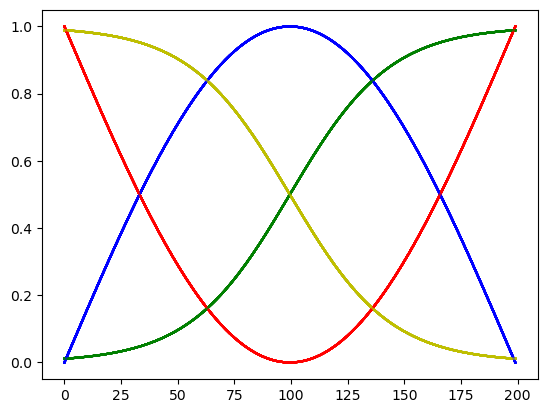

In [2]:
# Data generation
import matplotlib.pyplot as plt

dx = 1
t_steps = 200
num_train_per_class, num_val_per_class = 32, 8
num_classes = 4

x = torch.linspace(0, 1, t_steps).view(-1, 1)

generator_functions = [generate_sin, generate_cos, generate_cx_sigm, 
    generate_reverse_cx_sigm]
y = []
for i in range(num_train_per_class + num_val_per_class):
    for j in range(num_classes):
        y.append(generator_functions[j](x))

colors = ["b", "r", "g", "y"]
for i, y_i in enumerate(y):
    plt.plot(y_i, alpha=0.5, c=colors[i%num_classes])

x = x.unsqueeze(0).repeat(len(y), 1, 1).to(device)
y = torch.stack(y, dim=0).to(device)

vx, vy = x[num_train_per_class*num_classes:], y[num_train_per_class*num_classes:]
x, y = x[:num_train_per_class*num_classes], y[:num_train_per_class*num_classes]

print(x.shape, y.shape)
print(vx.shape, vy.shape)

In [3]:
batch_size = 32

model = CNP(input_dim=1, hidden_dim=204, output_dim=1, n_max_obs=6, n_max_tar=6, num_layers=3, batch_size=batch_size).to(device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

168506


In [4]:
def get_batch(x, y, traj_ids):
    dx, dy = x.shape[-1], y.shape[-1]
    n = x.shape[1]
    n_t = torch.randint(1, model.n_max_tar, (1,)).item()
    n_o = torch.randint(1, model.n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, n_o, dx+dy).to(device)
    tar = torch.zeros(batch_size, n_t, dx).to(device)
    tar_val = torch.zeros(batch_size, n_t, dy).to(device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(n)
        o_ids = random_query_ids[:n_o]
        t_ids = random_query_ids[n_o:n_o+n_t]

        # print(x.shape, traj_ids[i], o_ids, t_ids)

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    return obs, tar, tar_val

In [5]:
def get_validation_batch(vx, vy, o_ids=[0, -1]):
    obs = torch.cat((vx[:, o_ids, :], vy[:, o_ids, :]), dim=-1)
    tar = vx[:, torch.arange(t_steps)]
    tar_val= vy[:, torch.arange(t_steps)]

    return obs, tar, tar_val

In [6]:
import time

file_name = int(time.time())

epochs = 1000000
epoch_iter = 4

avg_loss = 0

val_per_epoch = 1000
min_val_loss = 1000000

mse_loss = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)

    for i in range(epoch_iter):
        optimizer.zero_grad()
        obs, tar_x, tar_y = get_batch(x, y, traj_ids[i])
        pred, encoded_rep = model(obs, tar_x)
        loss = model.loss(pred, tar_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            obs, tar_x, tar_y = get_validation_batch(vx, vy)
            pred, encoded_rep = model(obs, tar_x)
            val_loss = mse_loss(pred[:, :, :model.output_dim], tar_y)
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                print(f'New best: {min_val_loss}')
                torch.save(model.state_dict(), f'saved_models/cnp_synth_{file_name}.pt')

    avg_loss += epoch_loss

    if epoch % 100 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, avg_loss/100))
        avg_loss = 0

New best: 0.4005143642425537
Epoch: 0, Loss: 0.04520314931869507
Epoch: 100, Loss: 1.7685787364840508
Epoch: 200, Loss: 1.48487591907382
Epoch: 300, Loss: 1.2038644839823247
Epoch: 400, Loss: 0.5618093550170307
Epoch: 500, Loss: -0.09983563868328929
Epoch: 600, Loss: -0.8625746517954395
Epoch: 700, Loss: -1.55707087315619
Epoch: 800, Loss: -2.0700670011842157
Epoch: 900, Loss: -2.587321873777546
New best: 0.013109986670315266
Epoch: 1000, Loss: -3.094319752889569
Epoch: 1100, Loss: -3.2086051490902903
Epoch: 1200, Loss: -3.7348128514550627
Epoch: 1300, Loss: -3.719449091578499
Epoch: 1400, Loss: -3.941341086756438
Epoch: 1500, Loss: -4.311476893968647
Epoch: 1600, Loss: -4.354306411575526
Epoch: 1700, Loss: -4.614919297918678
Epoch: 1800, Loss: -4.724525697287172
Epoch: 1900, Loss: -5.023887976082042
New best: 0.0037093854043632746
Epoch: 2000, Loss: -5.0488387453556065
Epoch: 2100, Loss: -5.3923982788063585
Epoch: 2200, Loss: -5.375523561574519
Epoch: 2300, Loss: -5.418342949375511
Ep

KeyboardInterrupt: 

Text(0.5, 1.0, 'CNP (Easy)')

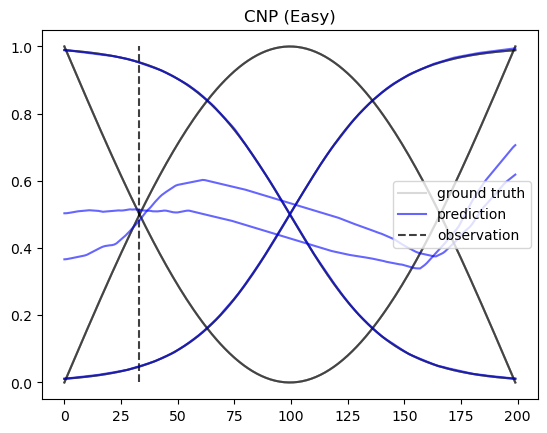

In [9]:
from matplotlib.lines import Line2D

def get_validation_batch(o_ids=[15]):
    obs = torch.cat((vx[:, o_ids, :], vy[:, o_ids, :]), dim=-1)
    tar = vx[:, torch.arange(t_steps)]
    tar_val= vy[:, torch.arange(t_steps)]

    return obs, tar, tar_val

file_name = '1691573215'

# Testing the best model
model = CNP(input_dim=1, hidden_dim=204, output_dim=1, n_max_obs=6, n_max_tar=6, num_layers=3, batch_size=batch_size)
model.load_state_dict(torch.load(f'saved_models/cnp_synth_{file_name}.pt'))
model.eval()

ids = [15]
o, t, tr = get_validation_batch(ids)
o, t, tr = o.cpu(), t.cpu(), tr.cpu()

with torch.no_grad():
    pred, _ = model(o, t)

p = pred.cpu().numpy()
t, tr = t.cpu().numpy(), tr.cpu().numpy()

for i in range(vx.shape[0]):
    plt.plot(range(t_steps), vy[i, :, 0].cpu(), 'k', alpha=0.15)

for i in range(len(ids)):
    plt.plot([ids[i]]*t_steps, torch.linspace(0, 1, t_steps), 'k--', alpha=0.75)

for i in range(4):
    plt.plot(range(t_steps), p[i, :, 0], 'b', alpha=0.6)

line0 = Line2D([0], [0], label=f'ground truth', color='k', alpha=0.15)
line1 = Line2D([0], [0], label=f'prediction', color='b', alpha=0.6)
line2 = Line2D([0], [0], label=f'observation', color='k', linestyle='--', alpha=0.75)

handles = [line0, line1, line2]

plt.legend(handles=handles, loc='best')
plt.title(f'CNP (Easy)')


In [ ]:
for i in range(200):
    for j in range(4):
        for k in range(4):
            if j!=k and abs(vy[j, i, 0]-vy[k, i, 0]) < 1e-2:
                print(i)

: 

In [ ]:
ids = [33]
o, t, tr = get_validation_batch(ids)
o, t, tr = o.cpu(), t.cpu(), tr.cpu()

with torch.no_grad():
    pred, _ = model(o, t)

p = pred.cpu().numpy()
t, tr = t.cpu().numpy(), tr.cpu().numpy()

for i in range(vx.shape[0]):
    plt.plot(range(t_steps), vy[i, :, 0].cpu(), 'k', alpha=0.15)

for i in range(len(ids)):
    plt.plot([ids[i]]*t_steps, torch.linspace(0, 1, t_steps), 'k--', alpha=0.75)

for i in range(4):
    plt.plot(range(t_steps), p[i, :, 0], 'b', alpha=0.6)

line0 = Line2D([0], [0], label=f'ground truth', color='k', alpha=0.15)
line1 = Line2D([0], [0], label=f'prediction', color='b', alpha=0.6)
line2 = Line2D([0], [0], label=f'observation', color='k', linestyle='--', alpha=0.75)

handles = [line0, line1, line2]

plt.legend(handles=handles, loc='best')
plt.title(f'CNP (Medium)')

: 

In [ ]:
ids = [60]
o, t, tr = get_validation_batch(ids)
o, t, tr = o.cpu(), t.cpu(), tr.cpu()

with torch.no_grad():
    pred, _ = model(o, t)

p = pred.cpu().numpy()
t, tr = t.cpu().numpy(), tr.cpu().numpy()

for i in range(vx.shape[0]):
    plt.plot(range(t_steps), vy[i, :, 0].cpu(), 'k', alpha=0.15)

for i in range(len(ids)):
    plt.plot([ids[i]]*t_steps, torch.linspace(0, 1, t_steps), 'k--', alpha=0.75)

for i in range(4):
    plt.plot(range(t_steps), p[i, :, 0], 'b', alpha=0.6)

line0 = Line2D([0], [0], label=f'ground truth', color='k', alpha=0.15)
line1 = Line2D([0], [0], label=f'prediction', color='b', alpha=0.6)
line2 = Line2D([0], [0], label=f'observation', color='k', linestyle='--', alpha=0.75)

handles = [line0, line1, line2]

plt.legend(handles=handles, loc='best')
plt.title(f'CNP (Difficult)')

: 

: 

: 